<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C6/C6.html"><img src="../data/C6_nav.png" width="100"  style="float:right;" alt="C6"></a>
<h1>Peak Picking</h1> 
</div>

<br/>

<p>
In this notebook, we compare different peak picking strategies using note onset detection as example task. Some of these strategies were developed by Nieto and Bello in the context of music structure analysis and by Böck et al. in the context of onset detection.
    
<ul>
<li><span style="color:black">
Oriol Nieto and Juan Pablo Bello: <strong>Systematic Exploration of Computational Music Structure Research.</strong> Proceedings of the International Society for Music Information Retrieval Conference (ISMIR), 2016, pp. 547&ndash;553.   
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_NietoB16_MSAF_ISMIR.txt"> Bibtex </a>
</span></li>
<li><span style="color:black">
Sebastian Böck, Florian Krebs, and Markus Schedl: <strong>Evaluating the Online Capabilities of Onset Detection Methods.</strong> Proceedings of the International Society for Music Information Retrieval Conference (ISMIR), 2012, pp. 49&ndash;54.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_BoeckKS12_EvalOnset_ISMIR.txt"> Bibtex </a>
</span></li>
</ul>       
</p> 

## Peak Picking

In the introductory [FMP notebook on onset detection](../C6/C6S1_OnsetDetection.html), we discussed that the positions of **peaks** (thought of well-defined local maxima) of the novelty function are good indicators for onset positions. Similarly, in the context of [music structure analysis](../C4/C4S4_NoveltySegmentation.html), the peak positions of a novelty function were used to derive segment boundaries between musical parts. In the case that the novelty function has a clear peak structure with impulse-like and well-separated peaks, the selection of peaks seems a simple problem. However, in practice, one often has to deal with rather noisy novelty functions that have many spurious peaks. In such situations, the strategy used for **peak picking** typically has a substantial influence on the quality of the final detection or segmentation result. 

* Often, simple **smoothing** operations may help to reduce the effect of noise-like fluctuations in the novelty function. 
* Also, **adaptive thresholding** strategies, where a peak is only selected when its value exceeds a local average of the novelty function, can be applied. 
* To further reduce the number of spurious peaks, another strategy is to impose a constraint on the **minimal distance** between two subsequent peak positions. 

In the following, we introduce several peak picking strategies that are based on various heuristics and depend on a number of different parameters. At this point, it is important to note that there is **no best** peak picking strategy per se&mdash;the suitability of a peak picking strategy very much depends on the requirements of the application in mind. On the one hand, unsuitable heuristics and parameter choices may lead to surprising and unwanted results. On the other hand, exploiting certain data statistics (e.g., minimum distance of two subsequent peaks) at the peak picking stage can lead to substantial improvements. Therefore, knowing the details of peak picking strategies and the often delicate interplay of their parameters is essential when building MIR systems.

## Running Example: Shostakovich

In the remainder of this notebook, we use a spectral-based novelty function computed for the Shostakovich example introduced in the [FMP notebook on novelty comparison](../C6/C6S1_NoveltyComparison.html). In the computation, we deliberately use parameter settings that lead to a novelty function that has some prominent peaks as well as a number of noise-like spurious peaks and unwanted secondary peaks. As for peak picking, we consider this a scenario of medium difficulty.

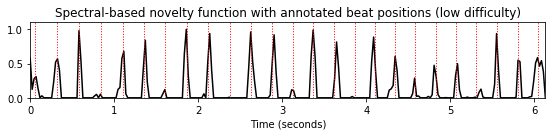

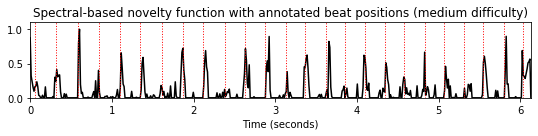

In [1]:
import numpy as np
import os, sys, librosa
from scipy import signal
from scipy.interpolate import interp1d
from scipy.ndimage import filters
from matplotlib import pyplot as plt
import IPython.display as ipd

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
%matplotlib inline

fn_ann = os.path.join('..', 'data', 'C6', 'FMP_C6_F07_Shostakovich_Waltz-02-Section_IncreasingTempo.csv')
ann, label_keys = libfmp.c6.read_annotation_pos(fn_ann, label='onset', header=0)

fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F07_Shostakovich_Waltz-02-Section_IncreasingTempo.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs)
x_duration = len(x)/Fs

N, H = 2048, 512
gamma = 10
nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=N, H=H, gamma=gamma)
figsize=(8,2)
fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, figsize=figsize, color='k', 
    title='Spectral-based novelty function with annotated beat positions (low difficulty)');
libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                nontime_axis=True, time_min=0, time_max=x_duration);

N, H = 1024, 256
gamma = 10
nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=N, H=H, gamma=gamma)
figsize=(8,2)
fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, figsize=figsize, color='k', 
    title='Spectral-based novelty function with annotated beat positions (medium difficulty)');
libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                nontime_axis=True, time_min=0, time_max=x_duration);

## Peak Picking: Simple Approach

Intuitively, a peak or local maximum is characterized by the property that the novelty curve changes from an increasing state (positive derivative) to a decreasing state (negative derivative). In the following, code cell, we define a first simple peak picking approach that looks for all such turning points. Furthermore, it discards peaks that lie below a specified threshold. 

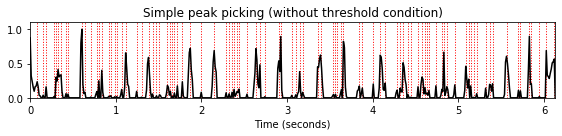

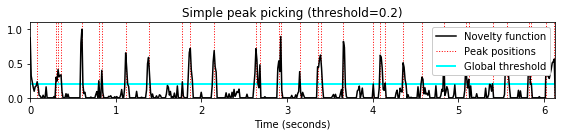

In [2]:
def peak_picking_simple(x, threshold=None):
    """Peak picking strategy looking for positions with increase followed by descrease

    Notebook: C6/C6S1_PeakPicking.ipynb

    Args:
        x: Input function
        threshold: Lower threshold for peak to survive

    Returns:
        peaks: Array containing peak positions
    """
    peaks = []
    if threshold is None:
        threshold = np.min(x) - 1
    for i in range(1, x.shape[0] - 1):
        if x[i - 1] < x[i] and x[i] > x[i + 1]:
            if x[i] >= threshold:
                peaks.append(i)
    peaks = np.array(peaks)
    return peaks

def plot_function_peak_positions(nov, Fs_nov, peaks, title='', figsize=(8,2)):
    peaks_sec = peaks/Fs_nov
    fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, figsize=figsize, color='k', title=title);
    plt.vlines(peaks_sec, 0, 1.1, color='r', linestyle=':', linewidth=1);

peaks = peak_picking_simple(nov, threshold=None)
title='Simple peak picking (without threshold condition)'
plot_function_peak_positions(nov, Fs_nov, peaks, title)

threshold = 0.2
peaks = peak_picking_simple(nov, threshold=threshold)
title='Simple peak picking (threshold=%.1f)'%threshold
plot_function_peak_positions(nov, Fs_nov, peaks, title)
plt.hlines(threshold, 0, x_duration, color='cyan', linewidth=2);
plt.legend(['Novelty function',  'Peak positions',  'Global threshold'], 
           loc='upper right', framealpha=1);

##  Peak Picking: MSAF

To reduce the effect of noise-like fluctuations, it is often beneficial to apply a smoothing filter to the novelty function. Furthermore, instead of considering a global threshold for discarding small, noise-like peaks, the idea of **adaptive thresholding** is to select a peak only in the case that its value exceeds a local average of the novelty function. A combination of these two strategies is applied in the following peak picking approach, which is used in the python package [MSAF (Music Structure Analysis Framework)](https://github.com/urinieto/msaf), see also the [paper by Nieto and Bello](https://zenodo.org/record/1417661#.XsyuMToza9I). 

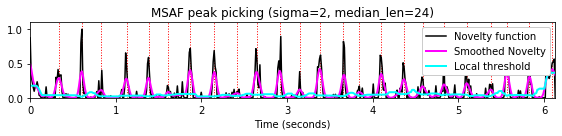

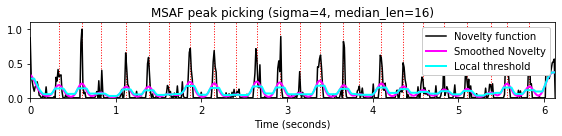

In [3]:
def peak_picking_MSAF(x, median_len=16, offset_rel=0.05, sigma=4):
    """Peak picking strategy following MSFA (https://github.com/urinieto/msaf)

    Notebook: C6/C6S1_PeakPicking.ipynb

    Args:
        x: Input function
        median_len: Length of media filter used for adaptive thresholding
        offset_rel: Additional offset used for adaptive thresholding
        sigma: Variance for Gaussian kernel used for smoothing the novelty function

    Returns:
        peaks: Array containing peak positions
    """
    offset = x.mean() * offset_rel
    x = filters.gaussian_filter1d(x, sigma=sigma)
    threshold_local = filters.median_filter(x, size=median_len) + offset
    peaks = []
    for i in range(1, x.shape[0] - 1):
        if x[i - 1] < x[i] and x[i] > x[i + 1]:
            if x[i] > threshold_local[i]:
                peaks.append(i)
    peaks = np.array(peaks)
    return peaks, x, threshold_local

median_len = 24
sigma=2
peaks, x_smooth, threshold_local = peak_picking_MSAF(nov, median_len=median_len, 
                                                     offset_rel=0.05, sigma=sigma)
title='MSAF peak picking (sigma=%1.0f, median_len=%2.0f)'%(sigma, median_len)
plot_function_peak_positions(nov, Fs_nov, peaks, title)
t = np.arange(nov.shape[0]) / Fs_nov 
plt.plot(t, x_smooth, color='magenta', linewidth=2);
plt.plot(t, threshold_local, color='cyan', linewidth=2);
plt.legend(['Novelty function', 'Smoothed Novelty', 'Local threshold'], 
           loc='upper right', framealpha=1);

median_len = 16
sigma=4
peaks, x_smooth, threshold_local = peak_picking_MSAF(nov, median_len=median_len, 
                                                     offset_rel=0.05, sigma=sigma)
title='MSAF peak picking (sigma=%1.0f, median_len=%2.0f)'%(sigma, median_len)
plot_function_peak_positions(nov, Fs_nov, peaks, title)
t = np.arange(nov.shape[0]) / Fs_nov 
plt.plot(t, x_smooth, color='magenta', linewidth=2);
plt.plot(t, threshold_local, color='cyan', linewidth=2);
plt.legend(['Novelty function',  'Smoothed Novelty', 'Local threshold'], 
           loc='upper right', framealpha=1);

## Peak Picking: Scipy

The signal processing package `scipy.signal` of `scipy` contains a [peak picking function called `find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html). This function takes a one-dimensional array and finds all local maxima by simple comparison of neighboring values. Optionally, a subset of these peaks can be selected by specifying conditions for a peak's properties. For a detailed description of this function, we refer to the [documentation page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) of this function. In the following, we consider three of the available parameters.

The [`prominence`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_prominences.html#scipy.signal.peak_prominences) parameter corresponds to the peak property that indicates how much a peak stands out from the surrounding baseline of the signal and is defined as the vertical distance between the peak and its lowest contour line.

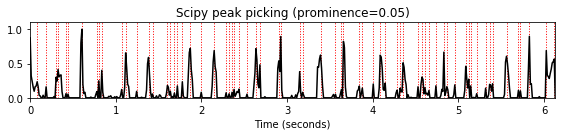

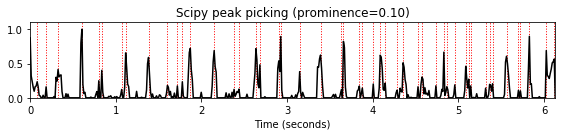

In [4]:
prominence = 0.05
peaks = signal.find_peaks(nov, prominence=prominence)[0]
title='Scipy peak picking (prominence=%.2f)'%prominence
plot_function_peak_positions(nov, Fs_nov, peaks, title)

prominence = 0.1
peaks = signal.find_peaks(nov, prominence=prominence)[0]
title='Scipy peak picking (prominence=%.2f)'%prominence
plot_function_peak_positions(nov, Fs_nov, peaks, title)

The [`height`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) parameter specifies the required height of peaks. It is either a number, `None`, an array matching the sequence, or a two-element sequence of the former. The first element is always interpreted as the minimal and the second, if supplied, as the maximal required height. In the following code cell, we give two examples: one with a globally defined threshold (minimal and maximal height) and one with a locally defined threshold curve (similar to the MSAF peak picking approach).

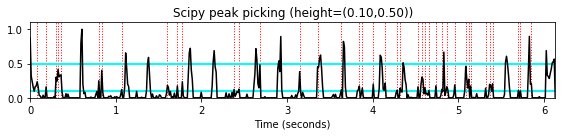

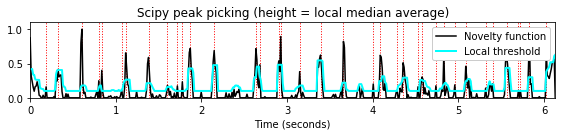

In [5]:
height = (0.1, 0.5)
peaks = signal.find_peaks(nov, height=height)[0]
title='Scipy peak picking (height=(%.2f,%.2f))'%(height[0],height[1])
plot_function_peak_positions(nov, Fs_nov, peaks, title)
plt.hlines(height[0], 0, x_duration, color='cyan', linewidth=2);
plt.hlines(height[1], 0, x_duration, color='cyan', linewidth=2);

height = filters.median_filter(nov, size=8) + 0.1
peaks = signal.find_peaks(nov, height=height)[0]
title='Scipy peak picking (height = local median average)'
plot_function_peak_positions(nov, Fs_nov, peaks, title)
t = np.arange(nov.shape[0]) / Fs_nov 
plt.plot(t, height, color='cyan', linewidth=2);
plt.legend(['Novelty function', 'Local threshold'], 
           loc='upper right', framealpha=1);

The [`distance`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) parameter specifies the required minimal horizontal distance (given in samples) between neighboring peaks. In this approach, smaller peaks are removed first until the condition is fulfilled for all remaining peaks. The distance condition is particularly useful of signals with certain periodicity properties, which imply minimum bounds for the distance. For example, in the case of [beat tracking](../C6/C6S2_TempoBeat.html), the expected maximal tempo yields such a minimum distance between two neighboring beat positions.

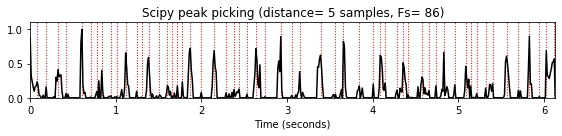

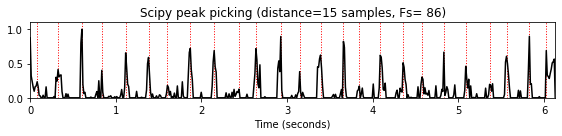

In [6]:
distance = 5
peaks = signal.find_peaks( nov, distance=distance)[0]
title='Scipy peak picking (distance=%2.0f samples, Fs=%3.0f)'%(distance, Fs_nov)
plot_function_peak_positions(nov, Fs_nov, peaks, title)

distance = 15
peaks = signal.find_peaks( nov, distance=distance)[0]
title='Scipy peak picking (distance=%2.0f samples, Fs=%3.0f)'%(distance, Fs_nov)
plot_function_peak_positions(nov, Fs_nov, peaks, title)

## Peak Picking: LibROSA

The Python library LibROSA also provides a [peak-picking function `librosa.util.peak_pick`](https://librosa.github.io/librosa/generated/librosa.util.peak_pick.html) with many tunable parameters. Given a signal `x`, it picks a sample `n` as a peak position if the following three conditions are fulfilled:

* The sample is maximal in a local neighborhood: <br>
  `x[n] == max(x[n - pre_max:n + post_max])`
* The sample is substantially larger than the neighborhood's mean: <br> 
  `x[n] >= mean(x[n - pre_avg:n + post_avg]) + delta`
* There is a minimal distance between two peak positions: <br>
  `n - previous_n > wait` (where `previous_n` is the peak position preceding `n`)

The distance conditions is implemented in a greedy fashion. The interplay of the various conditions (in combination with the greedy implementation) may lead to surprising result, where prominent peaks may be rejected. Such a situation is illustrated by the example given in the following code cell:

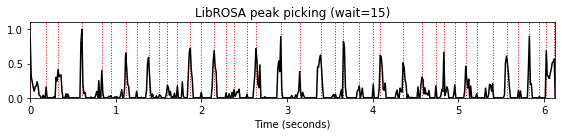

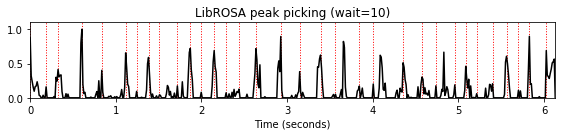

In [7]:
wait = 5
peaks = librosa.util.peak_pick(nov, pre_max=5, post_max=5, pre_avg=5, post_avg=5, 
                               delta=0.01, wait=wait)
title='LibROSA peak picking (wait=%2.0f)'%distance
plot_function_peak_positions(nov, Fs_nov, peaks, title)



wait = 10
peaks = librosa.util.peak_pick(nov, pre_max=5, post_max=5, pre_avg=5, post_avg=5, 
                               delta=0.01, wait=wait)
title='LibROSA peak picking (wait=%2.0f)'%wait
plot_function_peak_positions(nov, Fs_nov, peaks, title)

## Peak Picking: Boeck

The next peak-picking approach was introduced by Böck, Krebs, and Schedl in their paper on [Online Capabilities of Onset Detection Methods](https://zenodo.org/record/1416036#.Xs0ImToza9I). In the following code cell, we call a reimplementation of this method. 

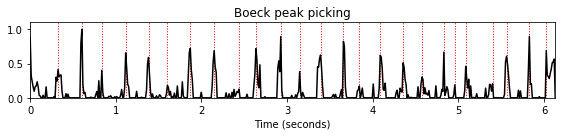

In [8]:
peaks = libfmp.c6.peak_picking_boeck(nov, threshold=0.01, fps=1, 
            include_scores=False, combine=0,
            pre_avg=0.1*Fs_nov, post_avg=0.1*Fs_nov, pre_max=0.1*Fs_nov, post_max=0.1*Fs_nov)
title='Boeck peak picking'
plot_function_peak_positions(nov, Fs_nov, peaks, title)

## Peak Picking: Roeder

Finally, we introduce a peak picking strategy originally implemented by Tido Röder. We call the function with its default settings (which are used when setting the parameters to `None`). For details we refer to the documentation in the function header. Finally, we call the function with the same parameters, this time applied to a smoothed version of the input signal. This examples demonstrates again that a simple pre-processing of the input signal can make the peak-picking process much easier (however, with the risk of losing relevant peaks, e.g, due to over-smoothing). 

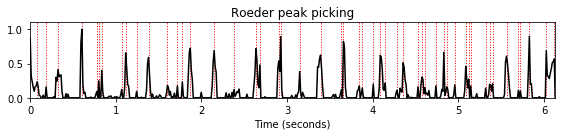

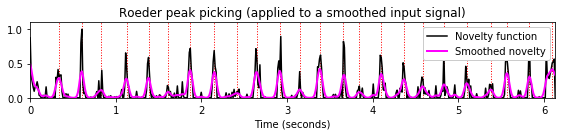

In [9]:
peaks = libfmp.c6.peak_picking_roeder(nov, direction=None, abs_thresh=None, 
                                      rel_thresh=None, descent_thresh=None, 
                                      tmin=None, tmax=None)
title='Roeder peak picking'
plot_function_peak_positions(nov, Fs_nov, peaks, title)

nov_smooth = filters.gaussian_filter1d(nov, sigma=2)
peaks = libfmp.c6.peak_picking_roeder(nov_smooth, direction=None, abs_thresh=None, 
                                      rel_thresh=None, descent_thresh=None, 
                                      tmin=None, tmax=None)
title='Roeder peak picking (applied to a smoothed input signal)'
plot_function_peak_positions(nov, Fs_nov, peaks, title)
t = np.arange(nov.shape[0]) / Fs_nov 
plt.plot(t, nov_smooth, color='magenta', linewidth=2);
plt.legend(['Novelty function', 'Smoothed novelty'], 
           loc='upper right', framealpha=1);

## Further Notes

In this notebook, we reviewed some strategies that are often applied in peak picking. Furthermore, we introduced some existing implementations that have been used in music processing tasks. We want to re-emphasize that peak picking typically exploits some heuristic which suitability depends on the intended application and data statistics. Often, peak picking strategy are based on (locally adapted) thresholds and distances, which are enforced in a greedy fashion. In the context of beat tracking, we will study peak [picking strategy that is globally optimized using dynamic programming](../C6/C6S3_BeatTracking.html).

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and Angel Villar-Corrales.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>